In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import scipy
from scipy.special import sph_harm
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import dipole
import tools

In [3]:
# construct theta and phi for healpix
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
theta, phi = hp.pix2ang(NSIDE, ipix=np.arange(NPIX))

In [6]:
def real_sph_harm(m, ell, theta, phi):
    if m < 0:
        res = (1j * np.sqrt(1/2) * \
               (sph_harm(-np.abs(m), ell, phi, theta) - (-1)**m * sph_harm(np.abs(m), ell, phi, theta))).real
    elif m > 0:
        res = np.sqrt(1/2) * \
                (sph_harm(-np.abs(m), ell, phi, theta) + (-1)**m * sph_harm(np.abs(m), ell, phi, theta)).real
    else:
        assert m == 0
        res = sph_harm(m, ell, phi, theta).real
    return res

### $Y_\ell^m$

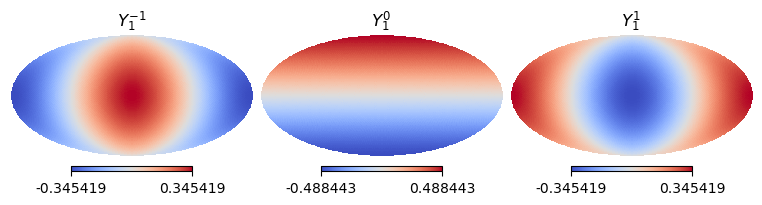

In [4]:
# scipy's function
n = 1
ms = np.linspace(-1,1,3)
# Y_lms
Y_lms = [
    sph_harm(m, n, phi, theta) for m in ms
]

# plot the real parts
titles = [r'$Y_1^{-1}$', r'$Y_1^0$', r'$Y_1^1$']
fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(Y_lms[i].real, title=titles[i], sub=(1,len(ms),i+1), cmap='coolwarm')

#### my dipole function

$$
\mathrm{"x"} = \sin\theta\,\cos\phi \\
\mathrm{"y"} = \sin\theta\,\sin\phi \\
\mathrm{"z"} = \cos\theta
$$

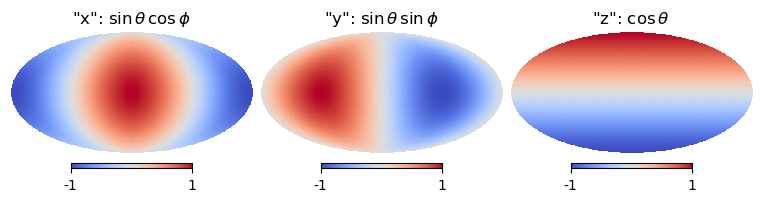

In [5]:
# my dipole function
titles = [
    r'"x": $\sin\theta\,\cos\phi$',
    r'"y": $\sin\theta\,\sin\phi$',
    r'"z": $\cos\theta$'
]

my_dip_comps = np.identity(3)
my_dipole_maps = [ dipole.dipole(theta, phi, *dip_comps) for dip_comps in my_dip_comps ]

fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(my_dipole_maps[i], title=titles[i], min=-1, max=1, sub=(1,len(ms),i+1), cmap='coolwarm', fig=fig)

According to the wiki here: https://en.wikipedia.org/wiki/Table_of_spherical_harmonics

the $\ell=1$ spherical harmonics are:
$$
Y_{1,-1} = i\sqrt{\frac{1}{2}}(Y_1^{-1} + Y_1^1) \\
Y_{1,0} = Y_1^0 \\
Y_{1,1} = \sqrt{\frac{1}{2}}(Y_1^{-1} - Y_1^1) \\
$$

In [15]:
def construct_dipole_map(theta, phi, amps):
    assert len(amps) == 3
    dipmap = np.zeros(len(theta))
    for i, m in enumerate(np.linspace(-1,1,3)):
        comp = real_sph_harm(m, 1, theta, phi)
        comp /= np.max(comp)
        dipmap += amps[i] * comp
    return dipmap

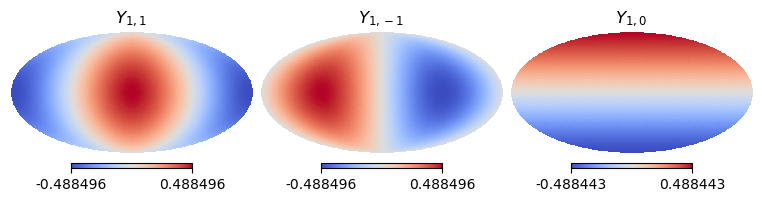

In [6]:
components = [
    # m = 1
    (np.sqrt(1/2) * (sph_harm(-1, 1, phi, theta) - sph_harm(1, 1, phi, theta))).real,
    # m = -1
    (1j * np.sqrt(1/2) * (sph_harm(-1, 1, phi, theta) + sph_harm(1, 1, phi, theta))).real,
    # m = 0
    sph_harm(0, 1, phi, theta).real
]

titles = [r'$Y_{1,1}$', r'$Y_{1,-1}$', r'$Y_{1,0}$']

fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(components[i], title=titles[i], sub=(1,len(ms),i+1), cmap='coolwarm')

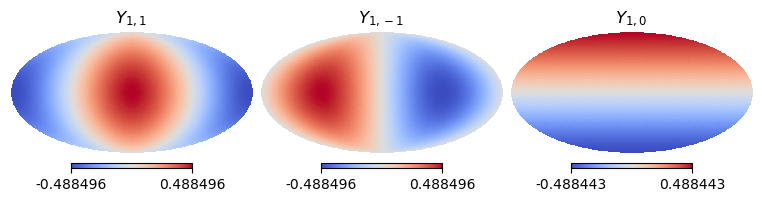

In [9]:
components = [
    real_sph_harm(m, 1, theta, phi) for m in [1,-1,0]
]

titles = [r'$Y_{1,1}$', r'$Y_{1,-1}$', r'$Y_{1,0}$']

fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(components[i], title=titles[i], sub=(1,len(ms),i+1), cmap='coolwarm')

### quadrupole

### $Y_{\ell m}$

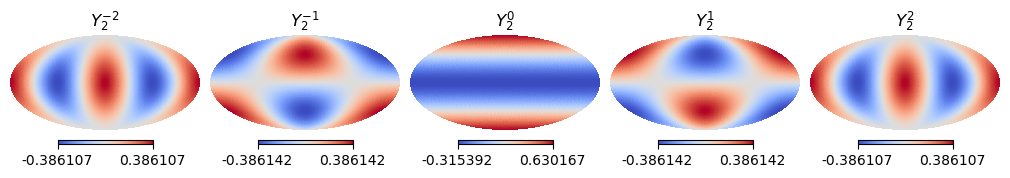

In [10]:
# scipy's function
n = 2
ms = np.linspace(-2,2,5)

titles = [r'$Y_2^{-2}$', r'$Y_2^{-1}$', r'$Y_2^0$', r'$Y_2^1$', r'$Y_2^2$']

fig = plt.figure(figsize=(2 * len(ms),2))
for i, m in enumerate(ms):
    dipole_map_scipy = sph_harm(m, n, phi, theta).real
    hp.mollview(dipole_map_scipy, title=titles[i], sub=(1,len(ms),i+1), cmap='coolwarm', fig=fig)

According to the same wiki page, the $\ell=2$ spherical harmonics are
$$
Y_{2,-2} = i\sqrt{\frac{1}{2}}(Y_2^{-2} - Y_2^2) \\
Y_{2,-1} = i\sqrt{\frac{1}{2}}(Y_2^{-1} + Y_2^1) \\
Y_{2,0} = Y_2^0 \\
Y_{2,1} = \sqrt{\frac{1}{2}}(Y_2^{-1} - Y_2^1) \\
Y_{2,2} = \sqrt{\frac{1}{2}}(Y_2^{-2} + Y_2^2)
$$

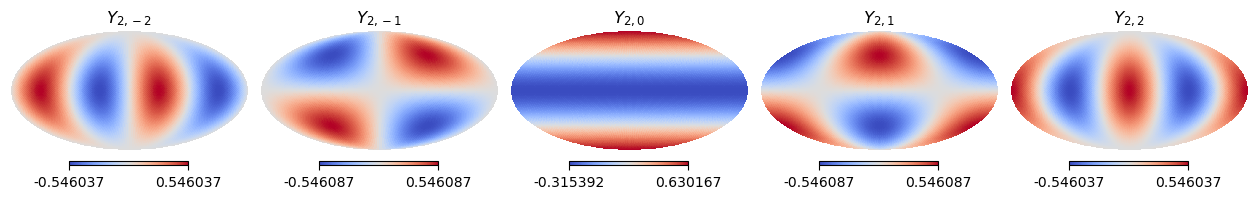

In [13]:
ms = np.linspace(-2,2,5)
components = [
    # m = -2
    np.sqrt(1/2) * (sph_harm(-2, 2, phi, theta) - sph_harm(2, 2, phi, theta)).imag,
    # m = -1
    np.sqrt(1/2) * (sph_harm(-1, 2, phi, theta) + sph_harm(1, 2, phi, theta)).imag,
    # m = 0
    sph_harm(0, 2, phi, theta),
    # m = 1
    np.sqrt(1/2) * (sph_harm(-1, 2, phi, theta) - sph_harm(1, 2, phi, theta)).real,
    # m = 2
    np.sqrt(1/2) * (sph_harm(-2, 2, phi, theta) + sph_harm(2, 2, phi, theta)).real
]

titles = [r'$Y_{2,-2}$', r'$Y_{2,-1}$', r'$Y_{2,0}$', r'$Y_{2,1}$', r'$Y_{2,2}$']

fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(components[i], title=titles[i], sub=(1,len(ms),i+1), cmap='coolwarm')

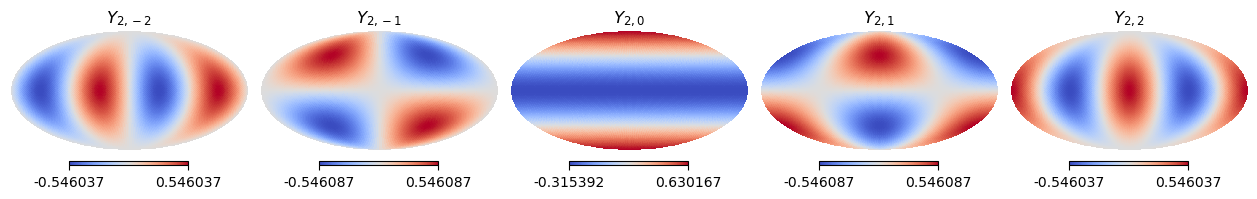

In [15]:
components = [
    real_sph_harm(m, 2, theta, phi) for m in np.linspace(-2,2,5)
]
titles = [r'$Y_{2,-2}$', r'$Y_{2,-1}$', r'$Y_{2,0}$', r'$Y_{2,1}$', r'$Y_{2,2}$']

fig = plt.figure(figsize=(2.5 * len(ms),2))
for i, m in enumerate(ms):
    hp.mollview(components[i], title=titles[i], sub=(1,len(ms),i+1), cmap='coolwarm')

### least-squares fit

In [16]:
def lstsq(Y, A, Cinv):
    """
    Return the least-squares solution to a linear matrix equation,
    given data Y, design matrix A, and inverse covariance Cinv.

    """
    if len(Cinv.shape)==1:  # if Cinv is a 1D array of the diagonal terms (variance)
        a = A.T @ (Cinv[:,None] * A)
        b = A.T @ (Cinv * Y)
    else:
        a = A.T @ Cinv @ A
        b = A.T @ Cinv @ Y
    res = np.linalg.lstsq(a, b, rcond=None)
    return res[0], a

In [17]:
def fit_multipole(map_to_fit, template_maps, Cinv=None, fit_zeros=False, idx=None):
    """
    Perform a least-squares fit to a healpix map.

    Parameters
    ----------
    map_to_fit : ndarray (healpix map) (NPIX,)
        Map of pixel values to fit.
    template_maps : ndarray (healpix maps) (NPIX,n)
        Template maps (the real parts of the spherical harmonics)
    Cinv : array-like, optional
        Inverse covariance matrix to use in the fit. If None, identity is used.

    Returns
    -------
    bestfit_pars : array-like
        Best-fit amplitudes: monopole (1) + dipole (3) + quadrupole (5) + ...
    bestfit_stderr : float
        Uncertainties on the best-fit amplitudes.
    """
    template_maps = np.array(template_maps)  # if input template_maps is a list
    assert map_to_fit.ndim == 1, "map to fit must be 1-dimensional"
    assert template_maps.ndim == 2, "template maps must be 2-dimensional"

    NPIX = len(map_to_fit)
    
    if template_maps.shape[1] == NPIX:
        template_maps = template_maps.T
    else:
        assert template_maps.shape[0] == NPIX, "template maps must match map to fit in length (NPIX)"

    # design matrix
    A = np.column_stack((np.ones(NPIX), template_maps))
    
    # covariance matrix
    if Cinv is None:
        Cinv = np.ones(NPIX)
    else:
        assert len(Cinv) == NPIX, "input Cinv and input map must have the same length"

    # indices to fit
    idx_to_fit = np.full(NPIX, True)
    if fit_zeros is False:
        idx_to_fit = idx_to_fit & (map_to_fit!=0.)
    if idx is not None:
        assert len(idx) == NPIX, "input idx and input map must have the same length"
        idx_to_fit = idx_to_fit & idx
    map_to_fit, A, Cinv = map_to_fit[idx_to_fit], A[idx_to_fit], Cinv[idx_to_fit]

    # perform the regression
    bestfit_pars, bestfit_Cinv = lstsq(map_to_fit, A, Cinv)

    # uncertainties on the best-fit pars
    bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

    return bestfit_pars, bestfit_stderr

#### sanity check: input a pure dipole component and make sure we get the right fit back

In [35]:
# input dipole map
dipole_comps = [0,1,0]
input_map = dipole.dipole(theta, phi, *dipole_comps)

array([ 1.00857142e-18,  9.99782963e-01,  2.80595019e-18, -4.81919930e-19])

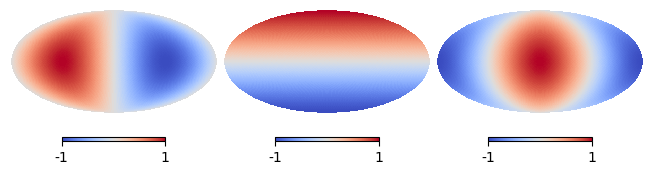

In [36]:
dipole_maps = np.empty((3,len(phi)))
for i, m in enumerate([-1,0,1]):
    map_ = real_sph_harm(m, 1, theta, phi)
    dipole_maps[i] = map_ / np.max(map_)

for i, component in enumerate(dipole_maps):
    hp.mollview(dipole_maps[i], sub=(1,3,i+1), min=-1, max=1, cmap='coolwarm', title='')

bestfit_pars, bestfit_stderr = fit_multipole(input_map, dipole_maps)
bestfit_pars

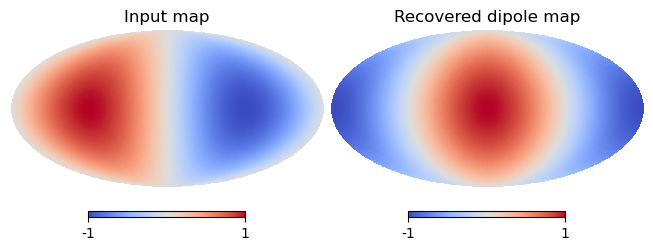

In [37]:
recovered_dipole_map = dipole.dipole(theta, phi, *bestfit_pars[1:])
kwargs = dict(cmap='coolwarm', min=-1, max=1)
hp.mollview(input_map, title='Input map', sub=(1,2,1), **kwargs)
hp.mollview(recovered_dipole_map, title='Recovered dipole map', sub=(1,2,2), **kwargs)

In [40]:
# input quadrupole map
quadrupole_comps = [1,1,0,0,0]
input_map = real_sph_harm(-2, 2, theta, phi)
input_map /= np.max(input_map)

array([-1.44999270e-18,  1.00000000e+00, -5.90976462e-16,  1.14112894e-15,
        6.54404128e-17,  2.26433065e-16])

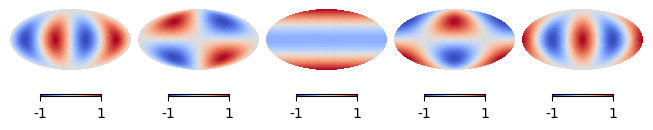

In [41]:
quadrupole_maps = np.empty((5,len(phi)))
for i, m in enumerate(np.linspace(-2,2,5)):
    map_ = real_sph_harm(m, 2, theta, phi)
    quadrupole_maps[i] = map_ / np.max(map_)

for i, component in enumerate(quadrupole_maps):
    hp.mollview(quadrupole_maps[i], sub=(1,5,i+1), min=-1, max=1, cmap='coolwarm', title='')

bestfit_pars, bestfit_stderr = fit_multipole(input_map, quadrupole_maps)
bestfit_pars

In [ ]:
recovered_dipole_map = dipole.dipole(theta, phi, *bestfit_pars[1:])
kwargs = dict(cmap='coolwarm', min=-1, max=1)
hp.mollview(input_map, title='Input map', sub=(1,2,1), **kwargs)
hp.mollview(recovered_dipole_map, title='Recovered dipole map', sub=(1,2,2), **kwargs)